<a href="https://colab.research.google.com/github/Saksham9804/Sigma-Task/blob/main/Quant_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import pickle

In [ ]:
ticker = 'RELIANCE.NS'
data = yf.download(ticker, start='2020-01-01', end='2025-07-19')
data.head()
print(data)

/tmp/ipython-input-76-3721359748.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start='2020-01-01', end='2025-07-19')
[*********************100%***********************]  1 of 1 completed

Price             Close         High          Low         Open      Volume
Ticker      RELIANCE.NS  RELIANCE.NS  RELIANCE.NS  RELIANCE.NS RELIANCE.NS
Date                                                                      
2020-01-01   678.021362   685.881324   676.179942   681.794149    14004468
2020-01-02   689.564331   692.101988   679.099372   679.099372    17710316
2020-01-03   690.395264   692.416395   684.039907   688.531297    20984698
2020-01-06   674.383423   686.240675   672.811418   682.692512    24519177
2020-01-07   684.758545   689.205022   679.773056   682.243314    16683622
...                 ...          ...          ...          ...         ...
2025-07-09  1519.000000  1551.000000  1510.099976  1536.699951     8870660
2025-07-10  1517.199951  1524.699951  1507.500000  1519.699951    10047129
2025-07-11  1495.199951  1515.000000  1490.300049  1512.000000     7234991
2025-07-14  1483.699951  1500.000000  1479.099976  1492.199951    10311846
2025-07-15  1485.400024  

In [ ]:
def adding_technical_indicators(df):
    df['SMA_10'] = df['Close'].rolling(window=10).mean()
    df['EMA_10'] = df['Close'].ewm(span=10, adjust=False).mean()
    df['RSI'] = compute_RSI(df['Close'], 14)
    df['BB_upper'], df['BB_lower'] = compute_bollinger_bands(df['Close'], 20)
    df['MACD'], df['MACD_signal'] = compute_MACD(df['Close'])
    df['Volatility'] = df['Close'].rolling(window=5).std()
    return df

def computing_RSI(series, period=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    RS = gain / loss
    return 100 - (100 / (1 + RS))

def computing_bollinger_bands(series, window):
    sma = series.rolling(window).mean()
    std = series.rolling(window).std()
    return sma + (2 * std), sma - (2 * std)

def computing_MACD(series):
    ema12 = series.ewm(span=12, adjust=False).mean()
    ema26 = series.ewm(span=26, adjust=False).mean()
    macd = ema12 - ema26
    signal = macd.ewm(span=9, adjust=False).mean()
    return macd, signal

data = add_technical_indicators(data)
data.dropna(inplace=True)
print(data)

Price             Close         High          Low         Open      Volume  \
Ticker      RELIANCE.NS  RELIANCE.NS  RELIANCE.NS  RELIANCE.NS RELIANCE.NS   
Date                                                                         
2020-01-28   661.021423   678.201038   657.360949   677.572201    24532236   
2020-01-29   664.659485   671.194432   657.563039   662.054429    24746565   
2020-01-30   648.445557   664.592121   646.761301   664.277732    22402689   
2020-01-31   634.028198   652.712421   632.029553   652.600109    34750310   
2020-02-03   622.283203   628.773298   612.200032   615.276642    30712290   
...                 ...          ...          ...          ...         ...   
2025-07-09  1519.000000  1551.000000  1510.099976  1536.699951     8870660   
2025-07-10  1517.199951  1524.699951  1507.500000  1519.699951    10047129   
2025-07-11  1495.199951  1515.000000  1490.300049  1512.000000     7234991   
2025-07-14  1483.699951  1500.000000  1479.099976  1492.199951  

In [ ]:
data['Future_Volatility'] = data['Close'].shift(-5).rolling(window=5).std()
data.dropna(inplace=True)

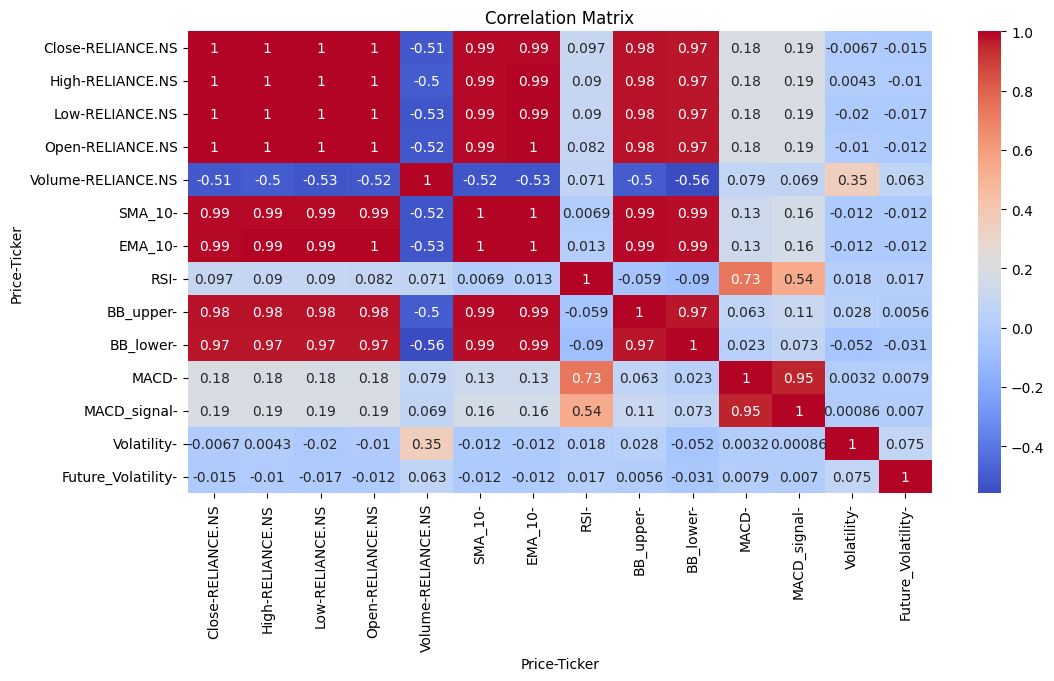

In [ ]:
plt.figure(figsize=(12, 6))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [ ]:
X = data[['SMA_10', 'EMA_10', 'RSI', 'BB_upper', 'BB_lower', 'MACD', 'MACD_signal', 'Volatility']]
y = data['Future_Volatility']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [ ]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

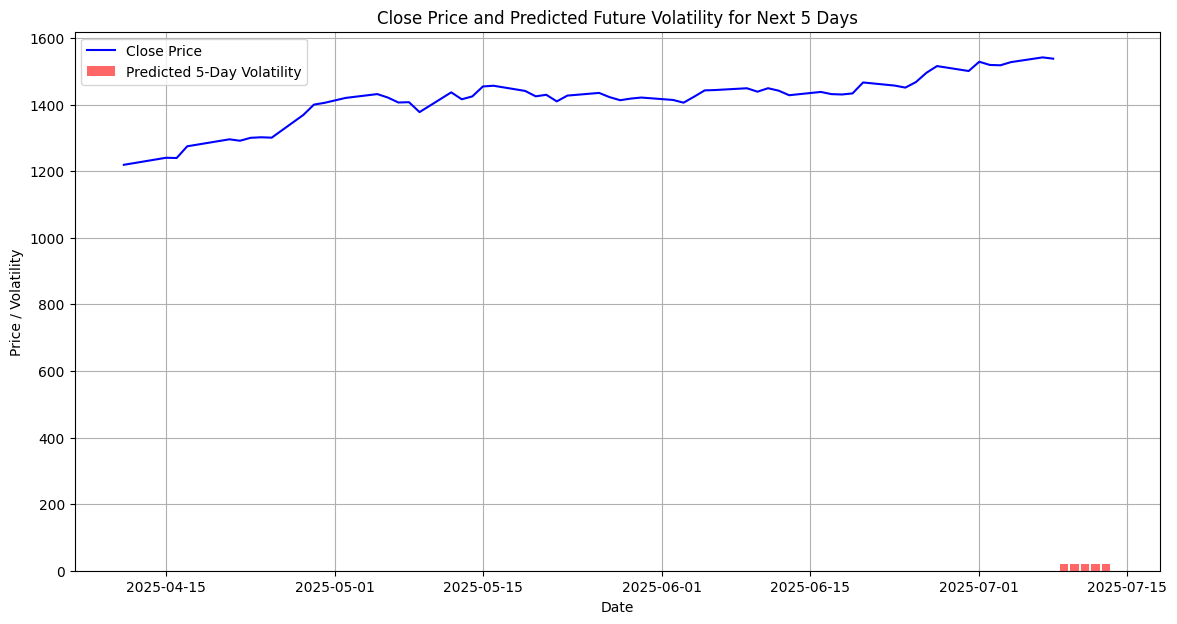

In [ ]:


# Getting the last row of feature inputs used for modeling
last_features = X.iloc[-1].values.reshape(1, -1)

# Predicting future volatility for the next 5 days using the last known features
future_predictions = []
for i in range(5):
    pred = model.predict(last_features)[0]
    future_predictions.append(pred)

# Preparing the next 5 calendar dates
last_date = data.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=5)

# Plotting the last 60 days of close price plus the next 5-day volatility prediction
plt.figure(figsize=(14, 7))
plt.plot(data.index[-60:], data['Close'][-60:], label='Close Price', color='blue')
plt.bar(future_dates, future_predictions, color='red', alpha=0.6, label='Predicted 5-Day Volatility')
plt.title('Close Price and Predicted Future Volatility for Next 5 Days')
plt.xlabel('Date')
plt.ylabel('Price / Volatility')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
with open('volatility_predictor.pkl', 'wb') as f:
    pickle.dump(model, f)


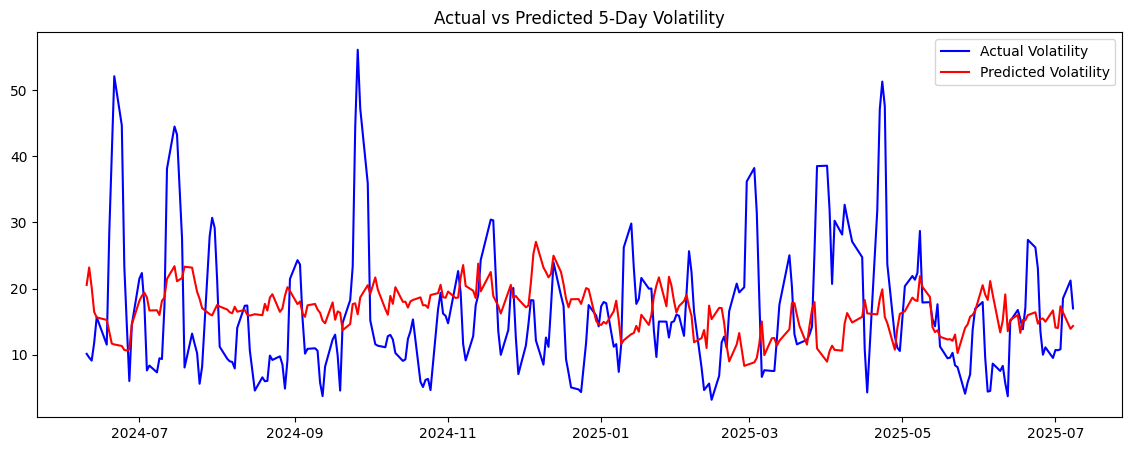

In [ ]:
plt.figure(figsize=(14, 5))
plt.plot(data.index[-len(y_test):], y_test, label="Actual Volatility", color='blue')
plt.plot(data.index[-len(y_test):], y_pred, label="Predicted Volatility", color='red')
plt.legend()
plt.title("Actual vs Predicted 5-Day Volatility")
plt.show()